# Example on Kattis MNIST Problem

https://open.kattis.com/problems/mnist2class

In [1]:
from itertools import product
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os

os.chdir('..')

from algen.selection import RouletteWheelSelection, TournamentSelection
from algen.trainer import Trainer


%load_ext autoreload
%autoreload 2

In [4]:
class BinaryNN:
    '''
    Class for Binary Neural Network

    Arguments
    ---------
    - num_classes: int, default 2

    - input_shape: int, default None
        must be specified if init_weights is not Numpy array

    - nodes_per_class: int, default 15
        the number of hidden nodes used for each class

    - init_weights: None, or Numpy array
        if Numpy array, should be in shape of (nodes_per_class * num_classes, input_shape)
    '''

    def __init__(self, num_classes=2, input_shape=51, nodes_per_class=15, init_weights=None):
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.nodes_per_class = nodes_per_class
        self.hidden_nodes = nodes_per_class * num_classes
        self.weights = init_weights.reshape((self.hidden_nodes, self.input_shape))

    def predict(self, X, batch_size=64):
        '''
        Arguments
        ---------
        - X: Numpy array
            Should be in shape of (num_samples, input_shape)

        - batch_size: int, default 128
            The number of samples used for each batch of computation to predict
        
        Returns
        -------
        - result: Numpy array
            prediction result in shape of (num_samples, 1)

        '''
        result = []
        
        for i in range(0, len(X), batch_size):
            x = X[i:i+batch_size]     # shape [batch_size, input_shape]
            x = x.dot(self.weights.T)   # shape [batch_size, hidden_nodes]

            class_sum = []
            for j in range(0, self.hidden_nodes, self.nodes_per_class):
                sum_class = x[:, j:j+self.nodes_per_class]
                sum_class = sum_class.sum(axis=1)
                class_sum.append(sum_class)

            class_sum = np.vstack(class_sum).T
            class_sum = class_sum.argmax(axis=1)
            result.append(class_sum)

        result = np.hstack(result).reshape(-1, 1)
        return result

def load_data(num_classes):
    df = pd.read_csv('./examples/sample_data/mnist%d_train.txt' % num_classes, sep=' ', header=None)
    features, labels = df.iloc[:, :-1].values, df.iloc[:, -1:].values
    return features, labels

# Two Class MNIST

In [5]:
NUM_CLASSES = 2
BATCH_SIZE = 16384
NODES_PER_CLASS = 15

seed = 42
num_generations = 5
pop_size = 50
crossover_rate = 0.95
mutation_rate = 0.15
chromosome_length = 51 * NODES_PER_CLASS * NUM_CLASSES

np.random.seed(seed)

X, y = load_data(NUM_CLASSES)
print('Data shape:', X.shape)

def fitness(chromosome):
    init_weights = 2 * chromosome.genotype - 1
    bnn = BinaryNN(num_classes=NUM_CLASSES, init_weights=init_weights)
    y_pred = bnn.predict(X, batch_size=BATCH_SIZE)
    return (y == y_pred).sum() / y.shape[0]

selection = TournamentSelection(tournament_size=5)

trainer = Trainer(
    chromosome_type='binary',
    chromosome_length=chromosome_length,
    fitness_function=fitness,
    pop_size=pop_size,
    selection=selection,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    seed=seed
)

history = trainer.run(num_generations=num_generations, verbose=2)

Data shape: (11846, 51)
[Generation 0] - 0:00:00 - Best fitness: 0.8025 - Average fitness: 0.6207
[Generation 1] - 0:00:00 - Best fitness: 0.8623 - Average fitness: 0.7021
[Generation 2] - 0:00:00 - Best fitness: 0.8647 - Average fitness: 0.7749
[Generation 3] - 0:00:00 - Best fitness: 0.8710 - Average fitness: 0.8372
[Generation 4] - 0:00:00 - Best fitness: 0.8712 - Average fitness: 0.8606
Best generation : 4
Best fitness    : 0.8712
Best chromosome : array([1, 1, 1, ..., 1, 0, 0])
Finished in 0:00:03 (avg 0.60s/gen)


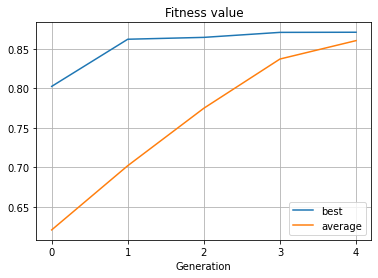

In [7]:
history = trainer.history['result'].set_index('generation')
history.plot(kind='line')

step = max(len(history) // 10, 1)
plt.xticks(history.index[::step])

plt.grid()
plt.xlabel('Generation')
plt.title('Fitness value')
plt.show()

In [8]:
best_solution = trainer.best_chromosome.genotype
best_solution = 2 * best_solution.reshape(51, NODES_PER_CLASS * NUM_CLASSES) - 1
best_solution = best_solution.tolist()

code = f'''A = {best_solution}

for a in A:
    print(' '.join(map(str, a)))
'''

# print(code)

# Grid Search on GA Parameters

## Two Class

In [10]:
NUM_CLASSES = 2
BATCH_SIZE = 16384
NODES_PER_CLASS = 15

seed = 42
num_generations = 20
chromosome_length = 51 * NODES_PER_CLASS * NUM_CLASSES

params_grid = dict(
    pop_size = [10],
    crossover_rate = [0.7],
    mutation_rate = [0.01],
    selection = [0, 2, 5]
)

grid = list(product(*params_grid.values()))
final_result = []

for trial, params in enumerate(grid):
    keys = params_grid.keys()
    kwargs = dict(zip(keys, params))
    print(f'\nTrial: {trial} from {len(grid)} -', kwargs)

    selection_kwargs = kwargs['selection']
    if selection_kwargs == 0:
        selection = RouletteWheelSelection()
    else:
        selection = TournamentSelection(tournament_size=selection_kwargs)
    kwargs.pop('selection')

    trainer = Trainer(
        chromosome_type='binary',
        chromosome_length=chromosome_length,
        fitness_function=fitness,
        selection=selection,
        seed=seed,
        **kwargs
    )

    trainer.run(num_generations=num_generations, verbose=1)

    result = kwargs.copy()
    result.update({
        'selection': selection_kwargs,
        'best_fitness': trainer.history['result']['best'].iloc[-1],
        'avg_runtime': trainer.history['avg_runtime'],
        'trial': trial
    })

    final_result.append(result)

final_result = pd.DataFrame(final_result)


Trial: 0 from 3 - {'pop_size': 10, 'crossover_rate': 0.7, 'mutation_rate': 0.01, 'selection': 0}
Best generation : 0
Best fitness    : 0.6453
Best chromosome : array([0, 1, 1, ..., 0, 0, 0])
Finished in 0:00:02 (avg 0.10s/gen)

Trial: 1 from 3 - {'pop_size': 10, 'crossover_rate': 0.7, 'mutation_rate': 0.01, 'selection': 2}
Best generation : 19
Best fitness    : 0.7865
Best chromosome : array([0, 1, 1, ..., 0, 0, 0])
Finished in 0:00:02 (avg 0.10s/gen)

Trial: 2 from 3 - {'pop_size': 10, 'crossover_rate': 0.7, 'mutation_rate': 0.01, 'selection': 5}
Best generation : 19
Best fitness    : 0.7277
Best chromosome : array([0, 1, 1, ..., 0, 0, 0])
Finished in 0:00:02 (avg 0.10s/gen)
